In [67]:
from IPython.display import Markdown, display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import traceback
import numpy as np
import scipy.stats as ss
import yaml
import itertools
import sys
import os
import subprocess
from os import path
import pickle
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

def printmd(*args):
    display(Markdown(' '.join(map(str, args))))

In [68]:
# !ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning_gen_circles/*" -s

In [69]:
# !ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning/*" -s

In [70]:
local_planner_color = {'dwa': 'blue', 'arena': 'orange', 'teb': 'green'}
local_planner_symbol = {'dwa': 'o', 'arena': '^', 'teb': 'x'}
robot_model_color = {'hunter': 'cyan', 'turtle': 'green'}
pd.options.display.width = 200
pd.options.display.max_rows = 0
pd.options.display.float_format = '{:,.3f}'.format
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['lines.linewidth'] = 2


In [71]:
df = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/local_planning/results.csv"))
with open(path.expanduser("~/ds/performance_modelling/output/local_planning/results_info.yaml")) as results_info_file:
    results_info = yaml.safe_load(results_info_file)

# df = pd.read_csv(path.expanduser("~/ds_alt/performance_modelling/output_plot_no_pedestrian_data/results.csv"))
# with open(path.expanduser("~/ds_alt/performance_modelling/output_plot_no_pedestrian_data/results_info.yaml")) as results_info_file:
#     results_info = yaml.safe_load(results_info_file)
    
df.rename(inplace=True, columns={
    'collisionless_localization_update_absolute_translation_error_mean': 'absolute_translation_error',
    'collisionless_localization_update_absolute_rotation_error_mean': 'absolute_rotation_error',
    'collisionless_localization_update_normalized_relative_translation_error_mean': 'normalized_relative_translation_error',
    'collisionless_localization_update_normalized_relative_rotation_error_mean': 'normalized_relative_rotation_error',
    'localization_update_rate_mean': 'localization_update_rate',
})

# turn odometry_error into beta_1..4
results_info['run_parameter_names'] += ['beta_1', 'beta_2', 'beta_3', 'beta_4']
results_info['run_parameter_names'].remove('odometry_error')
for i in range(0, 4):
    df[f'beta_{i+1}'] = df['odometry_error'].apply(lambda x: eval(x)[i])
del df['odometry_error']

df.loc[df.robot_model == 'turtlebot3_waffle_performance_modelling', 'robot_model'] = 'turtle'

run_parameters = [c for c in list(df.columns) if c in results_info['run_parameter_names']]
run_parameters += ['max_steering_angle_deg']
metrics_versions = [c for c in list(df.columns) if '_version' in c]
everything_else = ['run_id', 'session_id', 'run_number', 'goal_index']
metrics = [c for c in df.columns if c not in metrics_versions + run_parameters + everything_else]
metrics_and_versions = [c for c in list(df.columns) if '_version' in c or c in metrics]

cpu_time_metrics = [c for c in metrics if 'cpu_time' in c]
max_memory_metrics = [c for c in metrics if 'max_memory' in c]

# add useful parameters
df['session_id'] =  df['run_id'].apply(lambda x:  x.split('_')[1]+'_'+x.split('_')[2]+'_'+x.split('_')[3])
df['run_number'] =  df['run_id'].apply(lambda x:  int(x.split('_')[5]))
df[max_memory_metrics] = df[max_memory_metrics]/1024**2
df['max_steering_angle_deg'] = 90    # crea una nuova colonna e riempie le righe con il valore 90
df["run_index_str"] = df['run_index'].apply(lambda x: str(x))
df['goal_index'] = df.environment_name + '_' + df.run_index_str

# add metrics from existing ones
df['average_velocity'] = df['trajectory_length'] / df['execution_time']
df['success_rate'] = df['success_rate'] & (1 - df['collision_rate'])

metrics += ['average_velocity']
metrics_and_versions += ['average_velocity']

min_execution_time_group_df = df.groupby(["environment_name", "run_index", "success_rate"])
for (environment_name, run_index, success_rate), group_df in min_execution_time_group_df:
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'min_execution_time'] = group_df.execution_time.min()
df['norm_execution_time'] = df.execution_time / df.min_execution_time
metrics += ['norm_execution_time']
metrics_and_versions += ['norm_execution_time']

if True:
    printmd("## Number of Runs")
    printmd(f"    {len(df.run_id.unique())}")

    printmd("## Run Parameters")
    for name in [run_parameter_name for run_parameter_name in run_parameters if 'localization_generator_' not in run_parameter_name]:
        values = list(df[name].unique())
        printmd(f"    {name:<70}", sorted(values))

    printmd("## Metrics")
    for name in metrics_and_versions:
        if name in metrics_versions:
            if len(df[name].unique()) == 1:
                printmd(f"    {name:<70} {sorted(df[name].unique())}")
            else:
                printmd(f"<code><font style='background-color:yellow;font-family:monospace'>{name:<70}{sorted(df[name].unique())} </font></code> ⚠️")
        else:
            printmd(f"    {name:<70} min: {df[name].min(skipna=True):10.4g} {'avg':>15}: {df[name].mean(skipna=True):10.4g} {'max':>15}: {df[name].max(skipna=True):10.4g} {'nan':>15}: {sum(df[name].isna()):10.4g}")

## Number of Runs

    141

## Run Parameters

    amcl_alpha_factor                                                      [1.0]

    available_cpu_threads                                                  [8]

    environment_name                                                       ['7A-2', 'fr079', 'intel', 'mexico']

    global_planner_node                                                    ['global_planner']

    include_costmap_obstacles                                              [False, True]

    include_dynamic_obstacles                                              [False, True]

    local_planner_node                                                     ['teb']

    localization_node                                                      ['amcl']

    min_turning_radius                                                     [0.0, 0.1]

    pedestrian_number                                                      [0, 5]

    robot_model                                                            ['turtle']

    run_index                                                              [0, 1, 2, 3]

    run_replication_index                                                  [0]

    pedestrian_max_vel                                                     [nan, 0.3]

    beta_1                                                                 [0.01]

    beta_2                                                                 [0.0]

    beta_3                                                                 [0.01]

    beta_4                                                                 [0.0]

    max_steering_angle_deg                                                 [90]

## Metrics

    collision_rate                                                         min:          0             avg:     0.1489             max:          1             nan:          0

    collision_time                                                         min:      21.95             avg:      63.62             max:      162.7             nan:        120

    collision_rate_version                                                 [3]

    minimum_clearance                                                      min:          0             avg:     0.2608             max:      2.036             nan:          0

    average_clearance                                                      min:     0.1206             avg:     0.8613             max:      2.179             nan:          0

    median_clearance                                                       min:          0             avg:     0.7559             max:      2.192             nan:          0

    maximum_clearance                                                      min:     0.6143             avg:      1.952             max:      3.295             nan:          0

    clearance_version                                                      [3]

    trajectory_length                                                      min:     0.8497             avg:      23.54             max:      75.51             nan:          0

    trajectory_length_version                                              [1]

    execution_time                                                         min:      3.632             avg:        102             max:        327             nan:          0

    execution_time_version                                                 [1]

    success_rate                                                           min:          0             avg:     0.7801             max:          1             nan:          0

    success_rate_version                                                   [1]

    odometry_error_alpha_1_mean                                            min:   0.007995             avg:    0.09637             max:      1.997             nan:          0

    odometry_error_alpha_1_std                                             min:   0.004811             avg:     0.5304             max:      7.651             nan:          0

    odometry_error_alpha_2_mean                                            min:   0.001381             avg:     0.2229             max:      7.994             nan:          0

    odometry_error_alpha_2_std                                             min:   0.001454             avg:      1.189             max:      25.67             nan:          0

    odometry_error_alpha_3_mean                                            min:      0.011             avg:    0.01852             max:      0.163             nan:          0

    odometry_error_alpha_3_std                                             min:  0.0002965             avg:    0.04056             max:     0.6561             nan:          0

    odometry_error_alpha_4_mean                                            min:   0.001815             avg:    0.05224             max:     0.2422             nan:          0

    odometry_error_alpha_4_std                                             min:   0.002435             avg:    0.07708             max:      1.563             nan:          0

    odometry_error_version                                                 [2]

    localization_update_absolute_translation_error_mean                    min:    0.02277             avg:     0.2897             max:      6.482             nan:          0

    localization_update_absolute_translation_error_std                     min:   0.005706             avg:      0.216             max:      4.528             nan:          0

    localization_update_absolute_rotation_error_mean                       min:   0.005459             avg:    0.03483             max:     0.6738             nan:          0

    localization_update_absolute_rotation_error_std                        min:   0.003399             avg:    0.06154             max:     0.6199             nan:          0

    localization_update_relative_translation_error_mean                    min:   0.003043             avg:    0.01552             max:     0.1312             nan:          0

    localization_update_relative_translation_error_std                     min:   0.003102             avg:     0.0273             max:     0.5156             nan:          0

    localization_update_relative_rotation_error_mean                       min:   0.003048             avg:    0.01432             max:     0.1805             nan:          0

    localization_update_relative_rotation_error_std                        min:   0.002032             avg:    0.05977             max:     0.5961             nan:          0

    localization_update_normalized_relative_translation_error_mean         min:    0.03264             avg:     0.1871             max:      1.495             nan:          0

    localization_update_normalized_relative_translation_error_std          min:    0.02165             avg:     0.4976             max:      9.495             nan:          0

    localization_update_normalized_relative_rotation_error_mean            min:      0.024             avg:      0.132             max:      1.503             nan:          0

    localization_update_normalized_relative_rotation_error_std             min:    0.01908             avg:     0.5318             max:      5.537             nan:          0

    localization_update_error_version                                      [4]

    absolute_translation_error                                             min:    0.02185             avg:     0.2897             max:      6.482             nan:          0

    collisionless_localization_update_absolute_translation_error_std       min:   0.005706             avg:     0.2162             max:      4.528             nan:          0

    absolute_rotation_error                                                min:   0.005459             avg:     0.0344             max:     0.6738             nan:          0

    collisionless_localization_update_absolute_rotation_error_std          min:   0.003399             avg:    0.05897             max:     0.6199             nan:          0

    collisionless_localization_update_relative_translation_error_mean      min:   0.003043             avg:    0.01558             max:     0.1312             nan:          0

    collisionless_localization_update_relative_translation_error_std       min:   0.003102             avg:    0.02736             max:     0.5156             nan:          0

    collisionless_localization_update_relative_rotation_error_mean         min:   0.002959             avg:    0.01372             max:     0.1805             nan:          0

    collisionless_localization_update_relative_rotation_error_std          min:   0.002032             avg:    0.05614             max:     0.5961             nan:          0

    normalized_relative_translation_error                                  min:    0.03264             avg:     0.1879             max:      1.495             nan:          0

    collisionless_localization_update_normalized_relative_translation_error_std min:    0.02165             avg:     0.4963             max:      9.495             nan:          0

    normalized_relative_rotation_error                                     min:     0.0254             avg:     0.2044             max:      5.254             nan:          0

    collisionless_localization_update_normalized_relative_rotation_error_std min:    0.01908             avg:     0.7601             max:      27.97             nan:          0

    collisionless_localization_update_error_version                        [1]

    localization_update_rate                                               min:     0.2243             avg:     0.7282             max:      1.109             nan:          0

    localization_update_rate_std                                           min:    0.08119             avg:      0.324             max:       1.65             nan:          0

    localization_update_rate_version                                       [1]

    average_translation_velocity                                           min:    0.06187             avg:     0.2429             max:     0.3513             nan:          0

    average_rotation_velocity                                              min:    0.02892             avg:     0.2007             max:     0.6973             nan:          0

    translation_rotation_product                                           min:   0.007884             avg:    0.04513             max:     0.1662             nan:          0

    average_translation_acceleration                                       min:    0.02314             avg:      0.121             max:     0.2505             nan:          0

    average_rotation_acceleration                                          min:    0.03893             avg:      0.218             max:      1.056             nan:          0

    translation_rotation_acceleration_product                              min:   0.001397             avg:    0.03779             max:     0.1916             nan:          0

    average_velocity_atan                                                  min:    0.09708             avg:     0.4849             max:      1.346             nan:          0

    motion_characteristics_version                                         [4]

    move_base_cpu_time                                                     min:       0.89             avg:       37.6             max:      286.8             nan:          0

    simulation_cpu_time                                                    min:      19.76             avg:      141.2             max:      463.8             nan:          0

    system_cpu_time                                                        min:       3.91             avg:      49.13             max:      313.2             nan:          0

    move_base_max_memory                                                   min:      40.83             avg:       69.9             max:      161.7             nan:          0

    simulation_max_memory                                                  min:      343.6             avg:      470.2             max:      636.3             nan:          0

    system_max_memory                                                      min:      135.8             avg:      192.9             max:      352.6             nan:          0

    cpu_time_and_max_memory_version                                        [4]

    max_cmd_vel_translation                                                min:       0.26             avg:       0.26             max:       0.26             nan:          0

    max_cmd_vel_rotation                                                   min:      0.341             avg:     0.9598             max:          1             nan:          0

    mean_cmd_vel_translation                                               min:    0.01353             avg:     0.2287             max:     0.2599             nan:          0

    mean_cmd_vel_rotation                                                  min:    -0.6459             avg:    0.02595             max:     0.9221             nan:          0

    cmd_vel_metrics_version                                                [2]

    normalized_curvature                                                   min:   0.002605             avg:    0.02734             max:     0.1424             nan:          0

    normalized_curvature_version                                           [1]

    pedestrian_encounters                                                  min:          0             avg:       1.44             max:          6             nan:          0

    pedestrian_encounters_version                                          [4]

    average_velocity                                                       min:    0.06294             avg:     0.2256             max:     0.2648             nan:          0

    norm_execution_time                                                    min:      0.254             avg:      1.515             max:      18.64             nan:          0

In [72]:
df.groupby(by=['include_costmap_obstacles', 'include_dynamic_obstacles']).agg(['mean'])[['success_rate', 'move_base_cpu_time']].sort_values(by=('success_rate', 'mean'), ascending=False)

success_rate move_base_cpu_time
                                                            mean               mean
include_costmap_obstacles include_dynamic_obstacles                                
True                      True                             0.972             35.822
False                     False                            0.971             10.735
                          True                             0.889             10.138
True                      False                            0.265             96.235

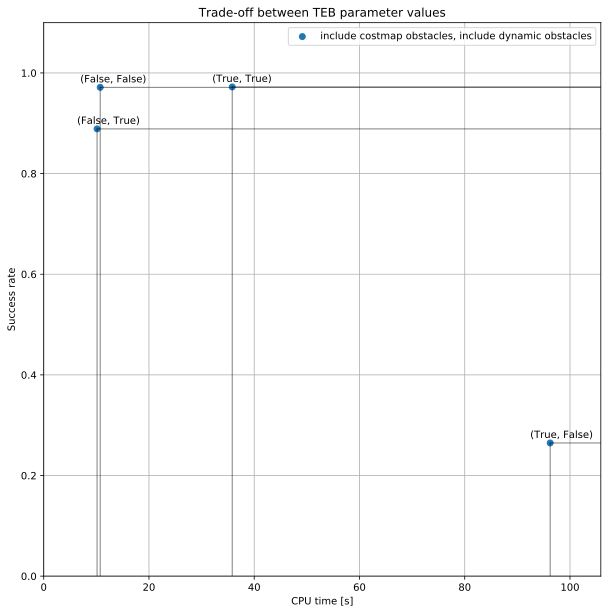

In [73]:
import matplotlib.patches as patches

df_success_cpu_trade_off = df.groupby(by=['include_costmap_obstacles', 'include_dynamic_obstacles']).agg('mean')[['success_rate', 'move_base_cpu_time']].sort_values(by='success_rate', ascending=False)

fig, ax = plt.subplots()

x = list(df_success_cpu_trade_off.move_base_cpu_time)
y = list(df_success_cpu_trade_off.success_rate)
labels = list(df_success_cpu_trade_off.index)

for x_i, y_i in zip(x, y):
    plt.plot([x_i, x_i+100], [y_i, y_i], color='black', linewidth=1, alpha=0.5)
    plt.plot([x_i, x_i], [-100, y_i], color='black', linewidth=1, alpha=0.5)

for i, label in enumerate(labels):
    ax.annotate(label, xy=(x[i], y[i]), xytext=(-20, 5) , xycoords='data', textcoords='offset points')

ax.scatter(df_success_cpu_trade_off.move_base_cpu_time, df_success_cpu_trade_off.success_rate, label=', '.join(df_success_cpu_trade_off.index.names).replace('_', ' '))
plt.xlabel('CPU time [s]')
plt.ylabel('Success rate')
plt.xlim([0, 1.1*df_success_cpu_trade_off.move_base_cpu_time.max()])
plt.ylim([0, 1.1])
plt.title("Trade-off between TEB parameter values")

plt.legend()
plt.grid()
plt.show()



In [13]:
df.groupby(by=['min_turning_radius', 'include_costmap_obstacles', 'include_dynamic_obstacles']).agg(['mean', 'count'])[['success_rate', 'collision_rate', 'move_base_cpu_time', 'move_base_max_memory']].sort_values(by=('success_rate', 'mean'), ascending=False)

success_rate       collision_rate       move_base_cpu_time       move_base_max_memory      
                                                                               mean count           mean count               mean count                 mean count
min_turning_radius include_costmap_obstacles include_dynamic_obstacles                                                                                            
0.000              False                     False                            1.000    16          0.000    16              7.686    16               70.746    16
                   True                      True                             1.000    18          0.000    18             28.907    18               67.737    18
0.100              False                     False                            0.947    19          0.000    19             13.303    19               69.090    19
                   True                      True                             0.944    18          0.000    18             42.736    18               64.574    18
                   False                     True                             0.909    22          0.000    22             10.776    22               61.420    22
0.000              False                     True                             0.857    14          0.000    14              9.136    14               84.104    14
                   True                      False                            0.375    16          0.500    16            110.600    16               75.732    16
0.100              True                      False                            0.167    18          0.722    18             83.466    18               71.633    18

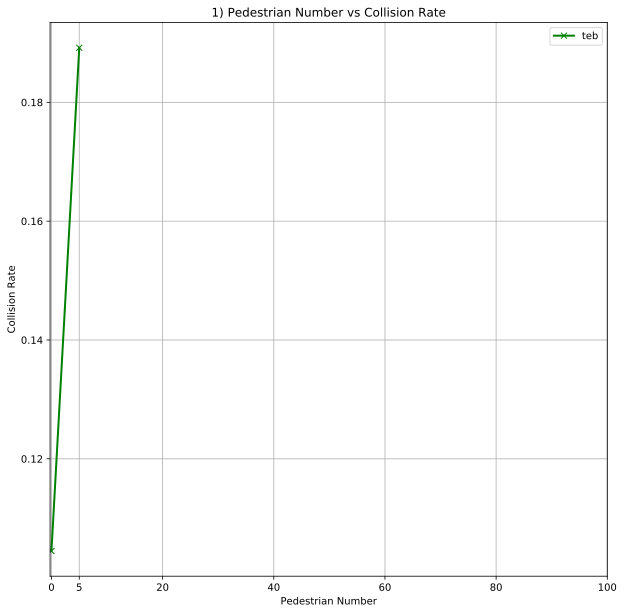

In [75]:
for local_planner_node in df.local_planner_node.unique():
    df_group = df[df.local_planner_node == local_planner_node].groupby(by='pedestrian_number')
    # raggruppiamo in base alla x e fai la media del collision rate
    df_collision_rate = df_group.agg('mean').collision_rate
    
    plt.plot(df_collision_rate.index, df_collision_rate, local_planner_symbol[local_planner_node] + '-', label=local_planner_node, color=local_planner_color[local_planner_node])
    
plt.xticks(sorted(list(set(range(0, 101, 20)).union(set([5])))))
plt.legend()
plt.xlabel('Pedestrian Number')
plt.ylabel('Collision Rate')
plt.title('1) Pedestrian Number vs Collision Rate')
plt.grid()
plt.show()

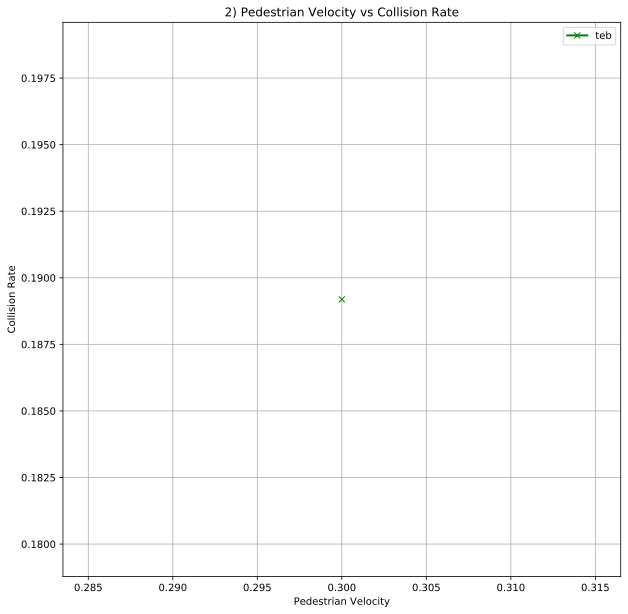

In [74]:
for local_planner_node in df.local_planner_node.unique():
    df_group = df[df.local_planner_node == local_planner_node].groupby(by='pedestrian_max_vel')
    # raggruppiamo in base alla x e fai la media del collision rate
    df_collision_rate = df_group.agg('mean').collision_rate
    
    plt.plot(df_collision_rate.index, df_collision_rate, local_planner_symbol[local_planner_node] + '-', label=local_planner_node, color=local_planner_color[local_planner_node])
    
plt.legend()
plt.xlabel('Pedestrian Velocity')
plt.ylabel('Collision Rate')
plt.title('2) Pedestrian Velocity vs Collision Rate')
plt.grid()
plt.show()

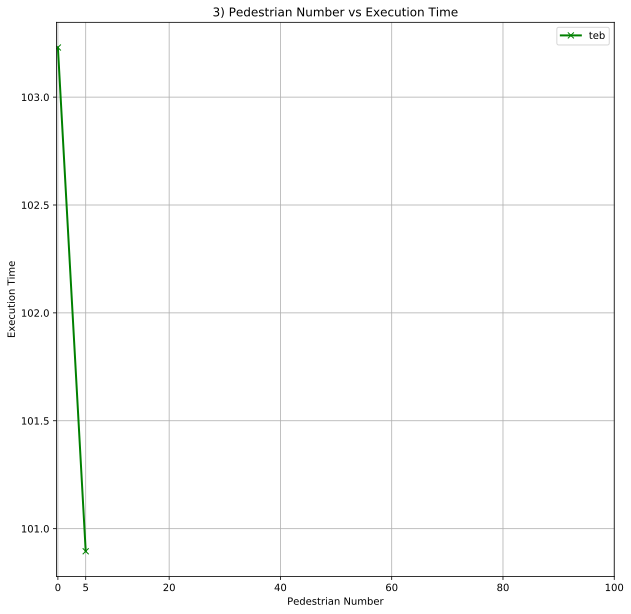

In [65]:
for local_planner_node in df.local_planner_node.unique():
    df_group = df[df.local_planner_node == local_planner_node].groupby(by='pedestrian_number')
    # raggruppiamo in base alla x e fai la media del collision rate
    df_execution_time = df_group.agg('mean').execution_time
    
    plt.plot(df_execution_time.index, df_execution_time, local_planner_symbol[local_planner_node] + '-', label=local_planner_node, color=local_planner_color[local_planner_node])
    
plt.xticks(sorted(list(set(range(0, 101, 20)).union(set([5])))))
plt.legend()
plt.xlabel('Pedestrian Number')
plt.ylabel('Execution Time')
plt.title('3) Pedestrian Number vs Execution Time')
plt.grid()
plt.show()

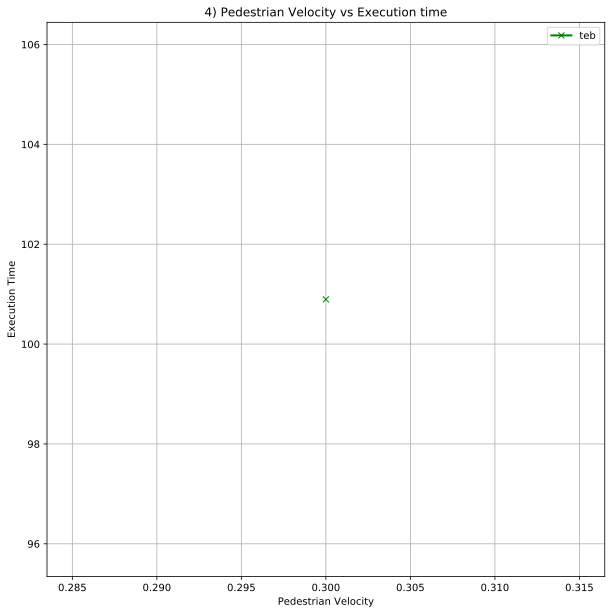

In [60]:
for local_planner_node in df.local_planner_node.unique():
    df_group = df[df.local_planner_node == local_planner_node].groupby(by='pedestrian_max_vel')
    # raggruppiamo in base alla x e fai la media del collision rate
    df_execution_time = df_group.agg('mean').execution_time
    
    plt.plot(df_execution_time.index, df_execution_time, local_planner_symbol[local_planner_node] + '-', label=local_planner_node, color=local_planner_color[local_planner_node])
    
plt.legend()
plt.xlabel('Pedestrian Velocity')
plt.ylabel('Execution Time')
plt.title('4) Pedestrian Velocity vs Execution time')
plt.grid()
plt.show()

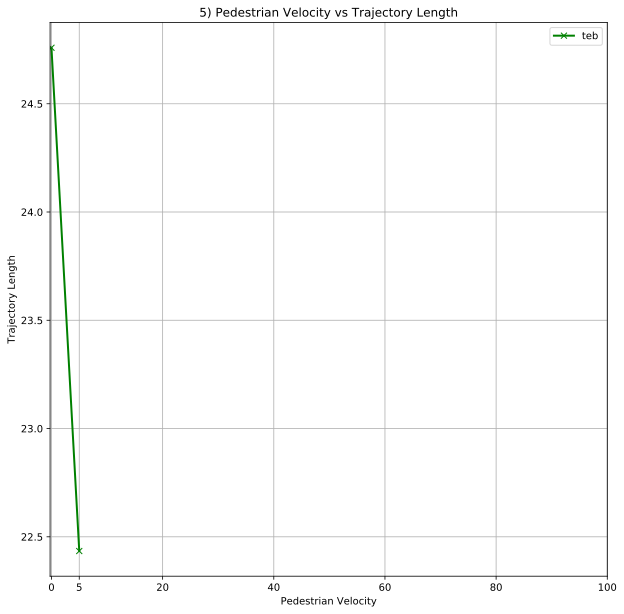

In [66]:
for local_planner_node in df.local_planner_node.unique():
    df_group = df[df.local_planner_node == local_planner_node].groupby(by='pedestrian_number')
    # raggruppiamo in base alla x e fai la media del collision rate
    df_execution_time = df_group.agg('mean').trajectory_length
    
    plt.plot(df_execution_time.index, df_execution_time, local_planner_symbol[local_planner_node] + '-', label=local_planner_node, color=local_planner_color[local_planner_node])
    
plt.xticks(sorted(list(set(range(0, 101, 20)).union(set([5])))))    
plt.legend()
plt.xlabel('Pedestrian Velocity')
plt.ylabel('Trajectory Length')
plt.title('5) Pedestrian Velocity vs Trajectory Length')
plt.grid()
plt.show()

In [11]:
df2 = df[(df.max_samples == 20)]
df2[["run_id", "environment_name", "run_index", "success_rate"]]


,run_id,environment_name,run_index,success_rate
0,session_2023-02-14_15-28-13_243746_run_000000000,7A-2,12,1
2,session_2023-02-14_15-28-13_243746_run_000000002,7A-2,2,1
4,session_2023-02-14_15-28-13_243746_run_000000004,7A-2,14,1
5,session_2023-02-14_15-28-13_243746_run_000000005,7A-2,5,1
6,session_2023-02-14_15-28-13_243746_run_000000006,7A-2,7,1
7,session_2023-02-14_15-28-13_243746_run_000000007,7A-2,1,1
8,session_2023-02-14_15-28-13_243746_run_000000008,7A-2,0,0
9,session_2023-02-14_15-28-13_243746_run_000000009,7A-2,6,0
12,session_2023-02-14_15-28-13_243746_run_000000012,7A-2,9,1
13,session_2023-02-14_15-28-13_243746_run_000000013,7A-2,3,1


In [11]:
df2 = df[(df.max_samples == 20)]
df2[["run_id", "environment_name", "run_index", "success_rate"]]


,run_id,environment_name,run_index,success_rate
0,session_2023-02-14_15-28-13_243746_run_000000000,7A-2,12,1
2,session_2023-02-14_15-28-13_243746_run_000000002,7A-2,2,1
4,session_2023-02-14_15-28-13_243746_run_000000004,7A-2,14,1
5,session_2023-02-14_15-28-13_243746_run_000000005,7A-2,5,1
6,session_2023-02-14_15-28-13_243746_run_000000006,7A-2,7,1
7,session_2023-02-14_15-28-13_243746_run_000000007,7A-2,1,1
8,session_2023-02-14_15-28-13_243746_run_000000008,7A-2,0,0
9,session_2023-02-14_15-28-13_243746_run_000000009,7A-2,6,0
12,session_2023-02-14_15-28-13_243746_run_000000012,7A-2,9,1
13,session_2023-02-14_15-28-13_243746_run_000000013,7A-2,3,1


In [12]:
df[['run_id', 'collision_rate']]

,run_id,collision_rate
0,session_2023-02-14_15-28-13_243746_run_000000000,0
1,session_2023-02-14_15-28-13_243746_run_000000001,0
2,session_2023-02-14_15-28-13_243746_run_000000002,0
3,session_2023-02-14_15-28-13_243746_run_000000003,0
4,session_2023-02-14_15-28-13_243746_run_000000004,0
5,session_2023-02-14_15-28-13_243746_run_000000005,0
6,session_2023-02-14_15-28-13_243746_run_000000006,0
7,session_2023-02-14_15-28-13_243746_run_000000007,0
8,session_2023-02-14_15-28-13_243746_run_000000008,0
...,...,...


In [13]:
# restituisce tutte le righe aventi arena e collision rate pari a 1. Ho splittato in 2 istruzioni come consigliato su stackoverflow, per evitare warning.
df2 = df[df.local_planner_node =='teb'] 
df2[df2.collision_rate == 1]

# scarta riga se c'è un nan nella metrica

,run_id,amcl_alpha_factor,environment_name,global_planner_node,local_planner_node,localization_node,max_samples,min_turning_radius,pedestrian_max_vel,pedestrian_number,...,beta_3,beta_4,session_id,run_number,max_steering_angle_deg,run_index_str,goal_index,average_velocity,min_execution_time,norm_execution_time


In [14]:
df[ (df.local_planner_node =='teb') & (df.success_rate == 1) ] 
# questo non scarta le righe contenenti i nan

,run_id,amcl_alpha_factor,environment_name,global_planner_node,local_planner_node,localization_node,max_samples,min_turning_radius,pedestrian_max_vel,pedestrian_number,...,beta_3,beta_4,session_id,run_number,max_steering_angle_deg,run_index_str,goal_index,average_velocity,min_execution_time,norm_execution_time
0,session_2023-02-14_15-28-13_243746_run_000000000,1.000,7A-2,global_planner,teb,amcl,20,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,0,90,12,7A-2_12,0.258,145.598,1.005
1,session_2023-02-14_15-28-13_243746_run_000000001,1.000,7A-2,global_planner,teb,amcl,10,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,1,90,7,7A-2_7,0.263,134.600,1.013
2,session_2023-02-14_15-28-13_243746_run_000000002,1.000,7A-2,global_planner,teb,amcl,20,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,2,90,2,7A-2_2,0.265,19.097,1.000
3,session_2023-02-14_15-28-13_243746_run_000000003,1.000,7A-2,global_planner,teb,amcl,10,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,3,90,2,7A-2_2,0.256,19.097,1.021
4,session_2023-02-14_15-28-13_243746_run_000000004,1.000,7A-2,global_planner,teb,amcl,20,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,4,90,14,7A-2_14,0.261,160.748,1.013
5,session_2023-02-14_15-28-13_243746_run_000000005,1.000,7A-2,global_planner,teb,amcl,20,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,5,90,5,7A-2_5,0.253,114.539,1.076
6,session_2023-02-14_15-28-13_243746_run_000000006,1.000,7A-2,global_planner,teb,amcl,20,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,6,90,7,7A-2_7,0.266,134.600,1.000
7,session_2023-02-14_15-28-13_243746_run_000000007,1.000,7A-2,global_planner,teb,amcl,20,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,7,90,1,7A-2_1,0.259,217.696,1.014
10,session_2023-02-14_15-28-13_243746_run_000000010,1.000,7A-2,global_planner,teb,amcl,10,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,10,90,1,7A-2_1,0.261,217.696,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [15]:
len(df2[df2.collision_rate == 1]) #restituisce il numero di righe

0

In [16]:
# alternativa se non si vogliono considerare i null values
df2[df2.collision_rate == 1].count()

run_id                    0
amcl_alpha_factor         0
environment_name          0
global_planner_node       0
local_planner_node        0
localization_node         0
max_samples               0
min_turning_radius        0
pedestrian_max_vel        0
pedestrian_number         0
robot_model               0
run_index                 0
                         ..
beta_1                    0
beta_2                    0
beta_3                    0
beta_4                    0
session_id                0
run_number                0
max_steering_angle_deg    0
run_index_str             0
goal_index                0
average_velocity          0
min_execution_time        0
norm_execution_time       0
Length: 99, dtype: int64

In [17]:
printmd("## Overall performance values by robot model, local planner component, kinematic constraints, and localization component")
printmd("### Considering all runs (sorted by collisionless success rate)")
df.groupby(['robot_model', 'local_planner_node', 'max_steering_angle_deg', 'localization_node'])[["success_rate", "collision_rate", "average_velocity", "norm_execution_time"]].agg(['mean', 'count']).sort_values(('success_rate', 'mean'), ascending=False)

## Overall performance values by robot model, local planner component, kinematic constraints, and localization component

### Considering all runs (sorted by collisionless success rate)

success_rate       collision_rate       average_velocity       norm_execution_time      
                                                                                mean count           mean count             mean count                mean count
robot_model local_planner_node max_steering_angle_deg localization_node                                                                                         
turtle      teb                90                     amcl                     0.765    34              0    34            0.245    34               0.954    30

In [18]:
printmd("### Only considering successful runs (sorted by norm execution time)")
df[df.success_rate == 1].groupby(['robot_model', 'local_planner_node', 'max_steering_angle_deg', 'localization_node'])[["success_rate", "collision_rate", "average_velocity", "norm_execution_time"]].agg(['mean', 'count']).sort_values(('norm_execution_time', 'mean'), ascending=True)

### Only considering successful runs (sorted by norm execution time)

success_rate       collision_rate       average_velocity       norm_execution_time      
                                                                                mean count           mean count             mean count                mean count
robot_model local_planner_node max_steering_angle_deg localization_node                                                                                         
turtle      teb                90                     amcl                         1    26              0    26            0.259    26               1.010    26

In [19]:
printmd("### Only considering failed runs (sorted by collision rate)")
df[df.success_rate == 0].groupby(['robot_model', 'local_planner_node', 'max_steering_angle_deg', 'localization_node'])[["success_rate", "collision_rate", "average_velocity", "norm_execution_time"]].agg(['mean', 'count']).sort_values(('collision_rate', 'mean'), ascending=True)

### Only considering failed runs (sorted by collision rate)

success_rate       collision_rate       average_velocity       norm_execution_time      
                                                                                mean count           mean count             mean count                mean count
robot_model local_planner_node max_steering_angle_deg localization_node                                                                                         
turtle      teb                90                     amcl                         0     8              0     8            0.199     8               0.587     4

## teb only, success rate

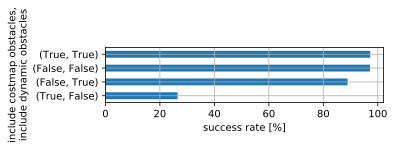

## teb only, collision rate

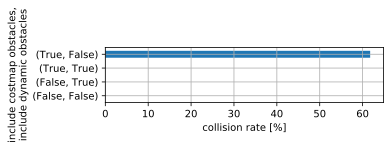

## teb only, cpu usage

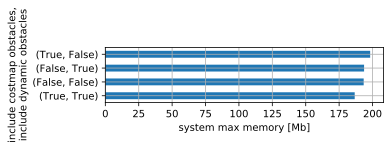

## teb only, cpu time

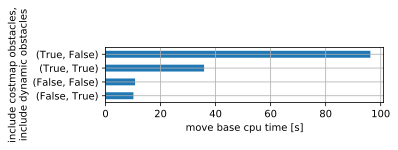

In [52]:
def bar_plot(metric_name, selected_df, y_columns=['local_planner_node'], percentage=False, unit_symbol=None, higher_better=True):
    bar_df = selected_df.groupby(y_columns)[metric_name].agg(['mean', 'count']).sort_values(by=('mean'), ascending=higher_better)
    ax = (bar_df.sort_values(by=('mean'), ascending=higher_better)* (100 if percentage else 1) ).plot.barh(y=[('mean')], stacked=True, figsize=[10, 5], grid=True, legend=False)
    ax.set_xlabel(metric_name.replace('_', ' ').replace(',', ', ') + (f" [{unit_symbol}]" if unit_symbol else ""))
    ax.set_ylabel(ax.get_ylabel().replace('_', ' ').replace(',', ',\n'))
    plt.gcf().set_size_inches([5, 1])
    plt.show()
# printmd("## success rate")
# bar_plot(metric_name='success_rate', selected_df=df[(df.max_steering_angle_deg == 90.0)], percentage=True, higher_better=True, unit_symbol='%')
# printmd("## collision_rate")
# bar_plot(metric_name='collision_rate', selected_df=df[(df.max_steering_angle_deg == 90.0)], percentage=True, higher_better=False, unit_symbol='%')
# printmd("## average_velocity, only successful runs")
# bar_plot(metric_name='average_velocity', selected_df=df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.0)], higher_better=True, unit_symbol='m/s')
# printmd("## norm_execution_time, only successful runs")
# bar_plot(metric_name='norm_execution_time', selected_df=df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.0)], higher_better=False, unit_symbol='s/s')
printmd("## teb only, success rate")
bar_plot(metric_name='success_rate', selected_df=df[(df.local_planner_node == 'teb')], y_columns=['include_costmap_obstacles', 'include_dynamic_obstacles'], percentage=True, higher_better=True, unit_symbol='%')
printmd("## teb only, collision rate")
bar_plot(metric_name='collision_rate', selected_df=df[(df.local_planner_node == 'teb')], y_columns=['include_costmap_obstacles', 'include_dynamic_obstacles'], percentage=True, higher_better=True, unit_symbol='%')
printmd("## teb only, cpu usage")
bar_plot(metric_name='system_max_memory', selected_df=df[(df.local_planner_node == 'teb')], y_columns=['include_costmap_obstacles', 'include_dynamic_obstacles'], higher_better=True, unit_symbol='Mb')
printmd("## teb only, cpu time")
bar_plot(metric_name='move_base_cpu_time', selected_df=df[(df.local_planner_node == 'teb')], y_columns=['include_costmap_obstacles', 'include_dynamic_obstacles'], higher_better=True, unit_symbol='s')

In [21]:
max_scatter_points = 200
def plot_in_out_metrics_bin_width_save(output_metric, input_metrics, bin_widths, min_bin_count, selected_df, out_dir, min_y=0.0, plot_all=True, scatter=True):
    max_y = -np.inf
#     scatter = False

    for i, (input_metric, bin_width) in enumerate(zip(input_metrics, bin_widths)):
        fig = plt.figure()

        for localization_node in df.localization_node.unique():
            for local_planner_node in df.local_planner_node.unique():
                
                df_lr = selected_df[
                    (selected_df.localization_node == localization_node) & 
                    (selected_df.local_planner_node == local_planner_node) & 
                    selected_df[input_metric.name].notna() & 
                    selected_df[output_metric.name].notna()
                ].copy()
                if len(df_lr[input_metric.name]):
                    if scatter:
                        n = max(1, int(len(df_lr[input_metric.name])/max_scatter_points))
                        plt.scatter(df_lr[input_metric.name][::n], df_lr[output_metric.name][::n], marker='.', s=0.25, color=local_planner_color[local_planner_node])
                    
                    if bin_width is not None:
                        if isinstance(bin_width, str):
                            _, bins = np.histogram(df_lr[input_metric.name], bins=bin_width)
                        else:
                            bins = np.arange(0., input_metric.max() + bin_width, bin_width)

                        df_lr['x_range'] = pd.cut(df_lr[input_metric.name], bins, labels=bins[:-1]).astype('float')
                        df_lr_g = df_lr.groupby('x_range').agg(['mean', 'count'])
                        df_lr_g = df_lr_g[ df_lr_g[(output_metric.name, 'count')] > min_bin_count ]
                        plt.plot(df_lr_g.index, df_lr_g[(output_metric.name, 'mean')], f'{local_planner_symbol[local_planner_node]}-', fillstyle='none', mfc=None, label=f'{local_planner_node}', linewidth=1, color=local_planner_color[local_planner_node])
                    else:
                        df_lr_g = df_lr.groupby(input_metric.name).agg(['mean', 'count'])
                        df_lr_g = df_lr_g[ df_lr_g[(output_metric.name, 'count')] > min_bin_count ]
                        plt.plot(df_lr_g.index, df_lr_g[(output_metric.name, 'mean')], f'{local_planner_symbol[local_planner_node]}-', fillstyle='none', mfc=None, label=f'{local_planner_node}', linewidth=1, color=local_planner_color[local_planner_node])
                    max_y = max(max_y, df_lr_g[(output_metric.name, 'mean')].max())

        if i == 0:
            plt.legend()
        plt.grid()
        plt.xlabel(input_metric.name.replace('_', ' '))
        plt.ylabel(output_metric.name.replace('_', ' '))
        plt.ylim([min_y, max_y*1.1])
        fig.set_size_inches([4, 4])
        if not path.exists(out_dir):
            os.makedirs(out_dir)
        fig.savefig(out_dir + f"/{output_metric.name}---{input_metric.name}.pdf".replace('_', '-'), bbox_inches='tight')
        plt.show()


In [2]:
printmd("## Localization perf from system features")

d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
min_bin_count = 10
input_metrics, bin_widths = zip(*[
    [d.average_velocity, 0.02], 
    [d.average_translation_velocity, 0.02], 
    #[d.average_velocity_atan, 0.1],
    [d.beta_1, None],
])
output_metrics = [
    d.absolute_translation_error,
    d.absolute_rotation_error,
    d.normalized_relative_translation_error,
    d.normalized_relative_rotation_error,
]
for output_metric in output_metrics:
    printmd(f"### {output_metric.name.replace('_', ' ')}")
    plot_in_out_metrics_bin_width_save(
        output_metric=output_metric, 
        input_metrics=input_metrics, 
        bin_widths=bin_widths,
        min_bin_count=min_bin_count,
        selected_df=d,
        out_dir="thesis_plots/localization",
    )


printmd("## Localization perf from own parameters")

d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.amcl_alpha_factor != 0)].copy()
min_bin_count = 10
input_metrics, bin_widths = zip(*[
    [d.amcl_alpha_factor, None],
])
output_metrics = [
    d.absolute_translation_error,
    d.absolute_rotation_error,
    d.normalized_relative_translation_error,
    d.normalized_relative_rotation_error,
]
for output_metric in output_metrics:
    printmd(f"### {output_metric.name.replace('_', ' ')}")
    plot_in_out_metrics_bin_width_save(
        output_metric=output_metric, 
        input_metrics=input_metrics, 
        bin_widths=bin_widths,
        min_bin_count=min_bin_count,
        selected_df=d,
        out_dir="thesis_plots/localization",
    )

NameError: name 'printmd' is not defined

In [ ]:
# printmd("## avg vel and avg vel atan are similar")
# d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
# input_metrics = [
#     d.average_translation_velocity,
#     d.average_rotation_velocity,
#     d.average_velocity_atan,
# ]
# bin_widths = [0.02, 0.05, 0.1]
# min_bin_count = 10
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.average_translation_velocity, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
#     scatter=True,
#     out_dir="thesis_plots/motion_char_self_correlation",
# )
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.average_rotation_velocity, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
#     scatter=True,
#     out_dir="thesis_plots/motion_char_self_correlation",
# )
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.average_velocity_atan, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
#     scatter=True,
#     out_dir="thesis_plots/motion_char_self_correlation",
# )

In [ ]:
# print(df.goal_index)

bin_widths = [None, None, None]
d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
input_metrics = [
    d.environment_name,
    d.run_duplicate_index,
    d.goal_index,
]

plot_in_out_metrics_bin_width_save(
    output_metric=d.minimum_clearance, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=10,
    selected_df=d,
    plot_all=False,
    scatter=False,
    out_dir="thesis_plots/local_planner",
)
plot_in_out_metrics_bin_width_save(
    output_metric=d.average_velocity, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=10,
    selected_df=d,
    plot_all=False,
    scatter=False,
    out_dir="thesis_plots/local_planner",
)

In [ ]:

# printmd("### norm trajectory length ← absolute translation error doesn't work because when absolute translation error is very small, the trajectories are very short and a small change in trajectory length causes a big change in norm trajectory length")

# for e in df.environment_name.unique():
#     printmd(f"## {e}")
#     bin_widths = [0.01]
#     min_bin_count = 10
#     d = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.environment_name == e)].copy()
#     input_metrics = [
#         d.absolute_translation_error, 
#     ]
#     plot_in_out_metrics_bin_width_save(
#         output_metric=d.min_trajectory_length, 
#         input_metrics=input_metrics, 
#         bin_widths=bin_widths,
#         min_bin_count=min_bin_count,
#         selected_df=d,
#         plot_all=False,
#         scatter=False,
#         out_dir=f"thesis_plots/local_planner/{e}",
#     )
    
#     plot_in_out_metrics_bin_width_save(
#         output_metric=d.trajectory_length, 
#         input_metrics=input_metrics, 
#         bin_widths=bin_widths,
#         min_bin_count=min_bin_count,
#         selected_df=d,
#         plot_all=False,
#         scatter=False,
#         out_dir=f"thesis_plots/local_planner/{e}",
#     )
#     plot_in_out_metrics_bin_width_save(
#         output_metric=d.norm_trajectory_length, 
#         input_metrics=input_metrics, 
#         bin_widths=bin_widths,
#         min_bin_count=min_bin_count,
#         selected_df=d,
#         plot_all=False,
#         min_y=1.0,
#         scatter=False,
#         out_dir=f"thesis_plots/local_planner/{e}",
#     )


In [ ]:

# printmd("### norm trajectory length, trajectory length ← other localization error metrics")

# for e in df.environment_name.unique():
#     printmd(f"## {e}")
#     bin_widths = [0.03]
#     min_bin_count = 10
#     d = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.environment_name == e)].copy()
#     input_metrics = [
#         d.normalized_relative_rotation_error, 
#     ]
#     plot_in_out_metrics_bin_width_save(
#         output_metric=d.min_trajectory_length, 
#         input_metrics=input_metrics, 
#         bin_widths=bin_widths,
#         min_bin_count=min_bin_count,
#         selected_df=d,
#         plot_all=False,
#         scatter=False,
#         out_dir=f"thesis_plots/local_planner/{e}",
#     )
#     plot_in_out_metrics_bin_width_save(
#         output_metric=d.trajectory_length, 
#         input_metrics=input_metrics, 
#         bin_widths=bin_widths,
#         min_bin_count=min_bin_count,
#         selected_df=d,
#         plot_all=False,
#         scatter=False,
#         out_dir=f"thesis_plots/local_planner/{e}",
#     )
#     plot_in_out_metrics_bin_width_save(
#         output_metric=d.norm_trajectory_length, 
#         input_metrics=input_metrics, 
#         bin_widths=bin_widths,
#         min_bin_count=min_bin_count,
#         selected_df=d,
#         plot_all=False,
#         min_y=1.0,
#         scatter=False,
#         out_dir=f"thesis_plots/local_planner/{e}",
#     )


## 7A-2

No handles with labels found to put in legend.


ValueError: Axis limits cannot be NaN or Inf

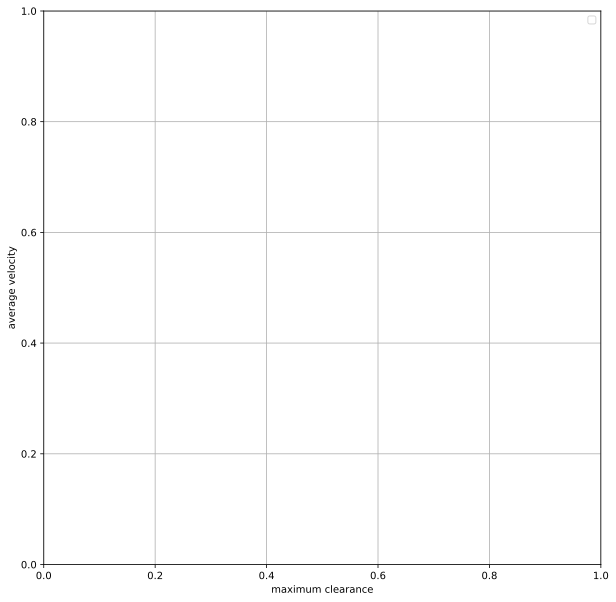

In [66]:


for e in df.environment_name.unique():
    printmd(f"## {e}")
    min_bin_count = 10
    d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.environment_name == e)].copy()
    bin_widths = [1, .1, .01]
    input_metrics = [
        d.maximum_clearance, 
        d.average_clearance, 
        d.minimum_clearance, 
    ]
    plot_in_out_metrics_bin_width_save(
        output_metric=d.average_velocity, 
        input_metrics=input_metrics, 
        bin_widths=bin_widths,
        min_bin_count=min_bin_count,
        selected_df=d,
        min_y=0.0,
        plot_all=False,
        scatter=True,
        out_dir=f"thesis_plots/local_planner/{e}",
    )


In [ ]:

printmd("## Local Planning perf (also system features)")

min_bin_count = 10
d = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
input_metrics, bin_widths = zip(*[
    [d.beta_1, None], 
    [d.amcl_alpha_factor, None],
    [d.minimum_clearance, .1],
    [d.average_clearance, 1],
])
plot_in_out_metrics_bin_width_save(
    output_metric=d.average_velocity, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=d,
    plot_all=False,
    scatter=True,
    out_dir="thesis_plots/local_planner",
)
plot_in_out_metrics_bin_width_save(
    output_metric=d.average_velocity_atan, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=d,
    plot_all=False,
    scatter=True,
    out_dir="thesis_plots/local_planner",
)

In [ ]:
## plots_local_planner

printmd("## Local Planning perf (not system features)")

min_bin_count = 10

d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
input_metrics, bin_widths = zip(*[
    [d.beta_1, None], 
    [d.amcl_alpha_factor, None],
    [d.average_clearance, 1],
])
plot_in_out_metrics_bin_width_save(
    output_metric=d.success_rate, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=d,
    out_dir="thesis_plots/local_planner",
    plot_all=False,
)
plot_in_out_metrics_bin_width_save(
    output_metric=d.collision_rate, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=d,
    out_dir="thesis_plots/local_planner",
    plot_all=False,
)

d = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
input_metrics, bin_widths = zip(*[
    [d.beta_1, None], 
    [d.amcl_alpha_factor, None],
    [d.minimum_clearance, .1],
    [d.average_clearance, 1],
])
plot_in_out_metrics_bin_width_save(
    output_metric=d.norm_trajectory_length, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=d,
    min_y=1.0,
    plot_all=False,
    out_dir="thesis_plots/local_planner",
)
plot_in_out_metrics_bin_width_save(
    output_metric=d.norm_execution_time, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=d,
    min_y=1.0,
    plot_all=False,
    out_dir="thesis_plots/local_planner",
)

In [ ]:
# ## plots_local_planner

# min_bin_count = 10

# d = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
# input_metrics, bin_widths = zip(*[
# #     [d.beta_1, None], 
# #     [d.amcl_alpha_factor, None],
# #     [d.minimum_clearance, .1],
# #     [d.average_clearance, 1],
#     [d.absolute_translation_error, 0.05],
#     [d.absolute_rotation_error, 0.01],
#     [d.normalized_relative_translation_error, 0.05],
#     [d.normalized_relative_rotation_error, 0.05],
# ])

# printmd("## norm_trajectory_length")
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.norm_trajectory_length, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
#     min_y=1.0,
#     plot_all=False,
#     scatter=True,
#     out_dir="thesis_plots/local_planner",
# )
# printmd("## norm_trajectory_length_std")
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.norm_trajectory_length_std, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
#     min_y=1.0,
#     plot_all=False,
#     scatter=True,
#     out_dir="thesis_plots/local_planner",
# )
# printmd("## norm_trajectory_length_mean")
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.norm_trajectory_length_mean, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
# #     min_y=1.0,
#     plot_all=False,
#     scatter=True,
#     out_dir="thesis_plots/local_planner",
# )
# printmd("## norm_trajectory_length_median")
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.norm_trajectory_length_median, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
# #     min_y=1.0,
#     plot_all=False,
#     scatter=True,
#     out_dir="thesis_plots/local_planner",
# )

In [67]:
df_s = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()

bins = np.arange(df_s.trajectory_length.min(), df_s.trajectory_length.max(), 5)
df_s['trajectory_length_d'] = pd.cut(df_s.trajectory_length, bins, labels=bins[:-1]).astype('float')
df_lr_g = df_s.groupby('trajectory_length_d').agg(['mean', 'count'])

plt.plot(df_lr_g.index, df_lr_g[('absolute_translation_error', 'mean')], label='all', color='black', linewidth=4)

for environment_name in df_s.environment_name.unique():
    df_lr_g = df_s[df_s.environment_name == environment_name].groupby('trajectory_length_d').agg(['mean', 'count'])
    plt.plot(df_lr_g.index, df_lr_g[('absolute_translation_error', 'mean')], label=environment_name)

plt.xlabel('trajectory_length_d')
plt.ylabel('absolute_translation_error')
plt.legend()
plt.grid()
plt.show()

ValueError: arange: cannot compute length

    trajectory_length_d  trajectory_length
0                29.720             29.720
1                 4.907              4.907
2                43.463             43.463
3                25.047             25.047
4                24.276             24.276
5                   nan                nan
6                37.561             37.561
7                23.860             23.860
8                39.187             39.187
..                  ...                ...
32               24.278             24.278
33               62.870             62.870
34                  nan                nan
35                3.712              3.712
36                6.434              6.434
37                  nan                nan
38               58.531             58.531
39               37.818             37.818
40                  nan                nan

[41 rows x 2 columns]


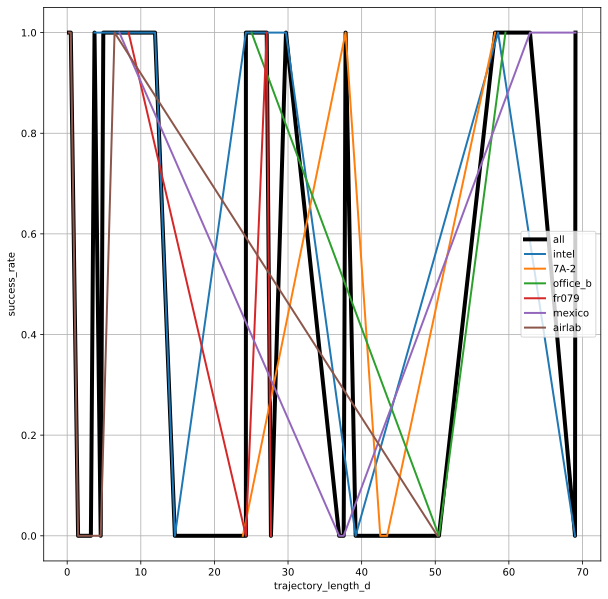

In [167]:
df_s = df.copy()

bins = np.arange(0, 100, 5)
# df_s['trajectory_length_d'] = pd.cut(df_s.trajectory_length, bins, labels=bins[:-1]).astype('float')
df_s['trajectory_length_d'] = df_s['trajectory_length']
print(df_s[['trajectory_length_d', 'trajectory_length']])
df_lr_g = df_s.groupby('trajectory_length_d').agg(['mean', 'count'])

plt.plot(df_lr_g.index, df_lr_g[('success_rate', 'mean')], label='all', color='black', linewidth=4)

for environment_name in df_s.environment_name.unique():
    df_lr_g = df_s[df_s.environment_name == environment_name].groupby('trajectory_length_d').agg(['mean', 'count'])
    plt.plot(df_lr_g.index, df_lr_g[('success_rate', 'mean')], label=environment_name)

plt.xlabel('trajectory_length_d')
plt.ylabel('success_rate')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# 